In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

data = pd.read_csv('Monthly_subspots.csv', parse_dates = True, index_col = 0).squeeze()
data.head()

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Sunspots, dtype: float64

In [9]:
data.describe()

count    2820.000000
mean       51.265957
std        43.448971
min         0.000000
25%        15.700000
50%        42.000000
75%        74.925000
max       253.800000
Name: Sunspots, dtype: float64

In [10]:
data.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2820 entries, 1749-01-01 to 1983-12-01
Series name: Sunspots
Non-Null Count  Dtype  
--------------  -----  
2820 non-null   float64
dtypes: float64(1)
memory usage: 44.1 KB


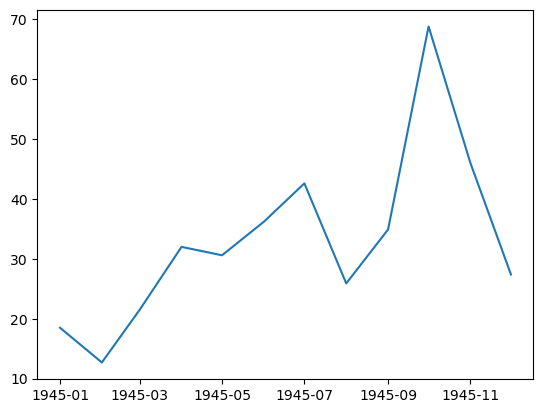

In [30]:
#visualization of yearn 1945
plt.plot(data['1945'])

<Axes: xlabel='Month'>

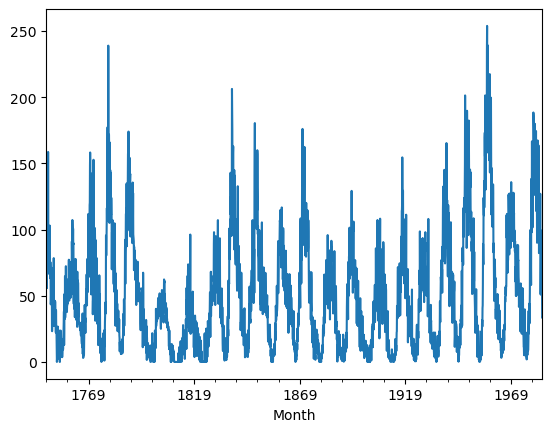

In [11]:
#visualization of data
data.plot()

In [12]:
#conduct test for stationarity
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -9.567667511913083
p-value: 2.333452143866205e-16
Critical Values:
	1%: -3.432694313168895
	5%: -2.862575752726396
	10%: -2.5673213632123297


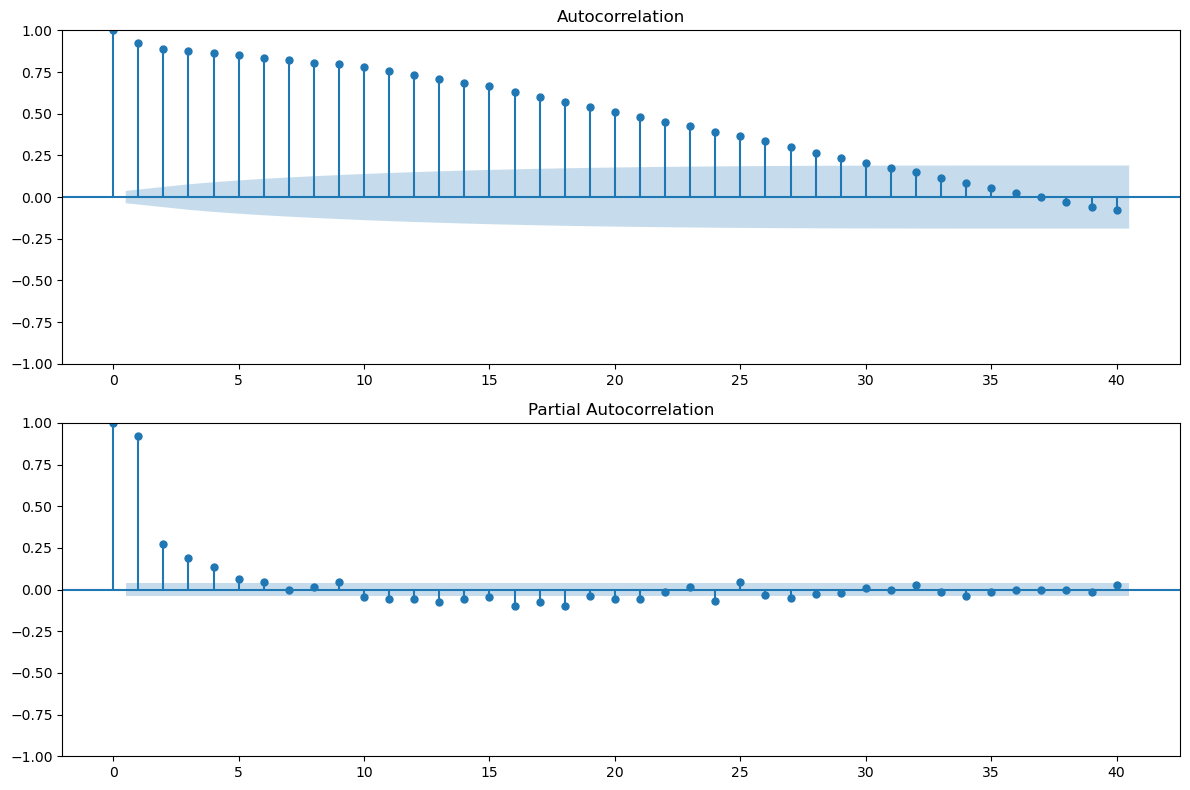

In [14]:
#plot ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data, lags=40, ax=ax1)
plot_pacf(data, lags=40, ax=ax2)
plt.tight_layout()
plt.show()

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (1, 1, 1)          # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, m) where m is the seasonal period

# Split data into train and test
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Print model summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Sunspots   No. Observations:                 2256
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -9281.388
Date:                            Fri, 28 Mar 2025   AIC                          18572.776
Time:                                    09:12:08   BIC                          18601.354
Sample:                                01-01-1749   HQIC                         18583.209
                                     - 12-01-1936                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2241      0.029      7.635      0.000       0.167       0.282
ma.L1         -0.6639      0.023   

In [17]:
import warnings
warnings.filterwarnings('ignore')

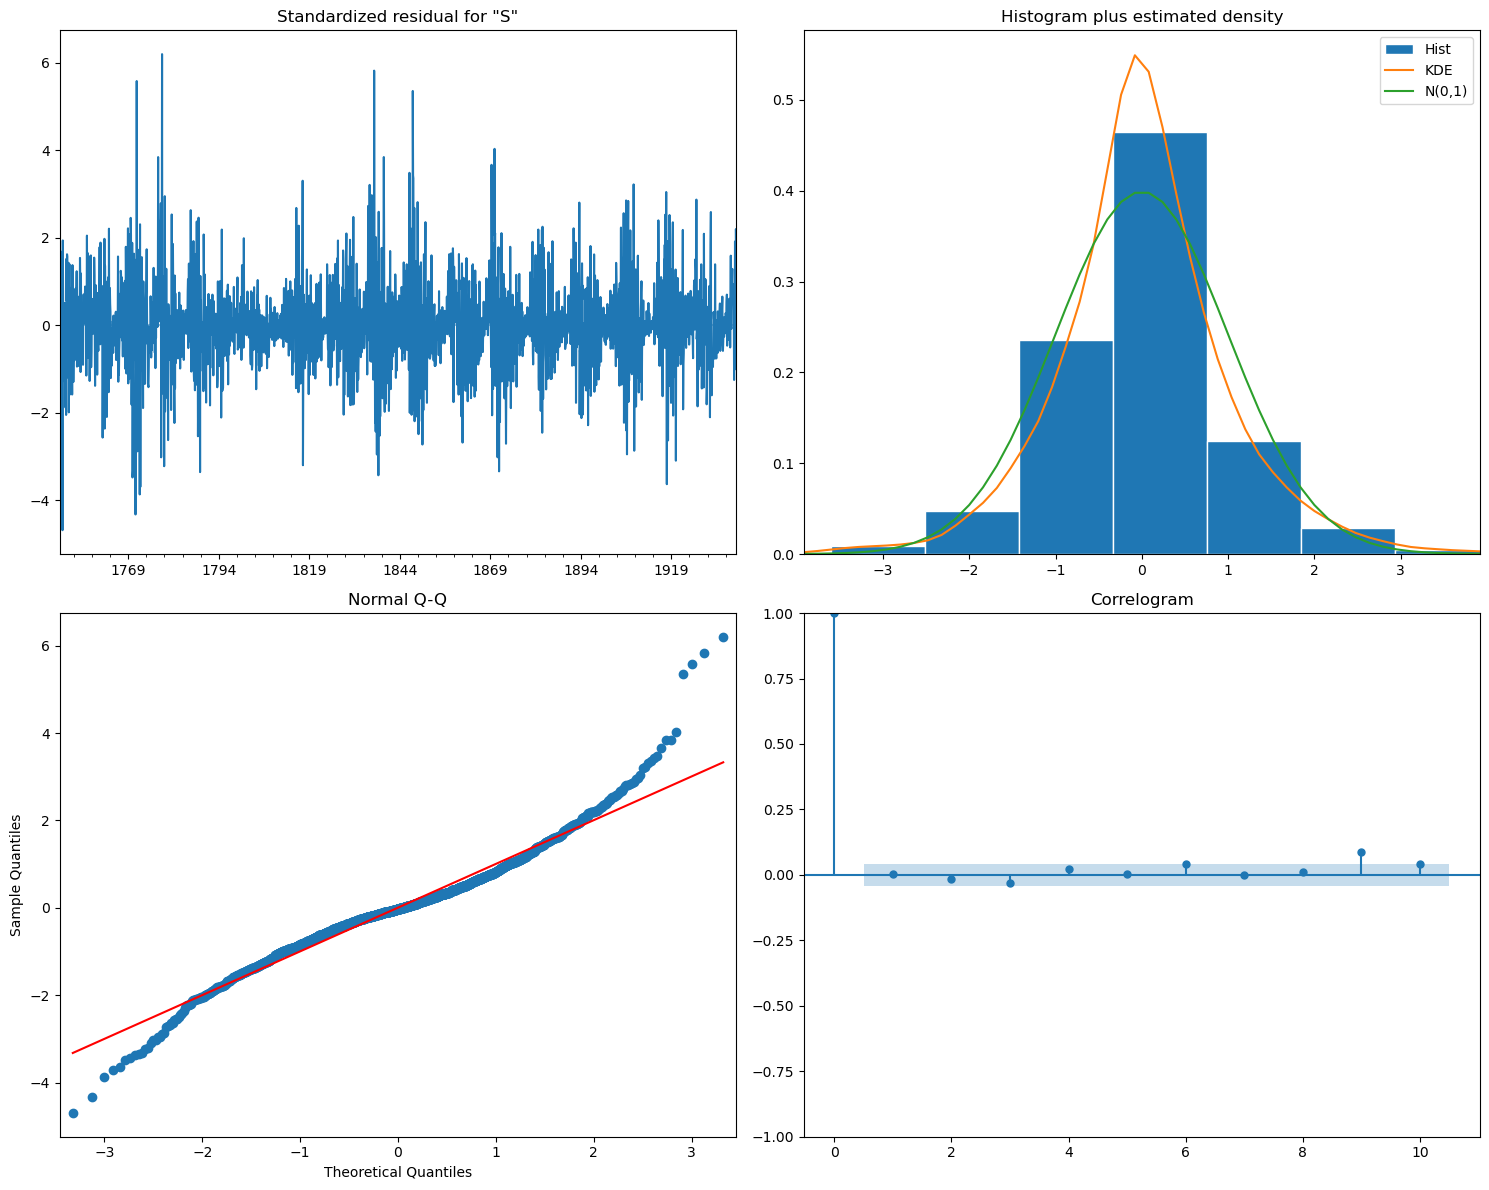

In [19]:
#plot diagnostic models
model_fit.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

In [22]:
#Finding best SARIMA parameters based on trial and error
from itertools import product
from tqdm import tqdm_notebook
ps = range(0, 3)  # AR order
qs = range(0, 3)  # MA order
Ps = range(0, 2)  # Seasonal AR order
Qs = range(0, 2)  # Seasonal MA order
d = 1             # Differencing order
D = 1             # Seasonal differencing order
m = 12            # Seasonal period

# Create all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

# Function to evaluate SARIMA models
def optimize_SARIMA(parameters_list, d, D, m):
    """
    Return dataframe with parameters and corresponding AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order
    D - seasonal integration order
    m - length of season
    """
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try:
            model = SARIMAX(train, order=(param[0], d, param[1]),
                          seasonal_order=(param[2], D, param[3], m)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        
        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_model, best_param

# Run optimization
result_table, best_model, best_param = optimize_SARIMA(parameters_list, d, D, m)

# Show top 5 parameter combinations
print(result_table.head())

# Best parameters
p, q, P, Q = best_param
print(f'\nBest SARIMA parameters: SARIMA({p},{d},{q})({P},{D},{Q})_{m}')

  0%|          | 0/36 [00:00<?, ?it/s]

     parameters           aic
0  (0, 2, 1, 1)  18572.356515
1  (1, 1, 1, 1)  18572.776306
2  (2, 1, 1, 1)  18573.057604
3  (1, 2, 1, 1)  18573.630556
4  (0, 2, 0, 1)  18573.681790

Best SARIMA parameters: SARIMA(0,1,2)(1,1,1)_12


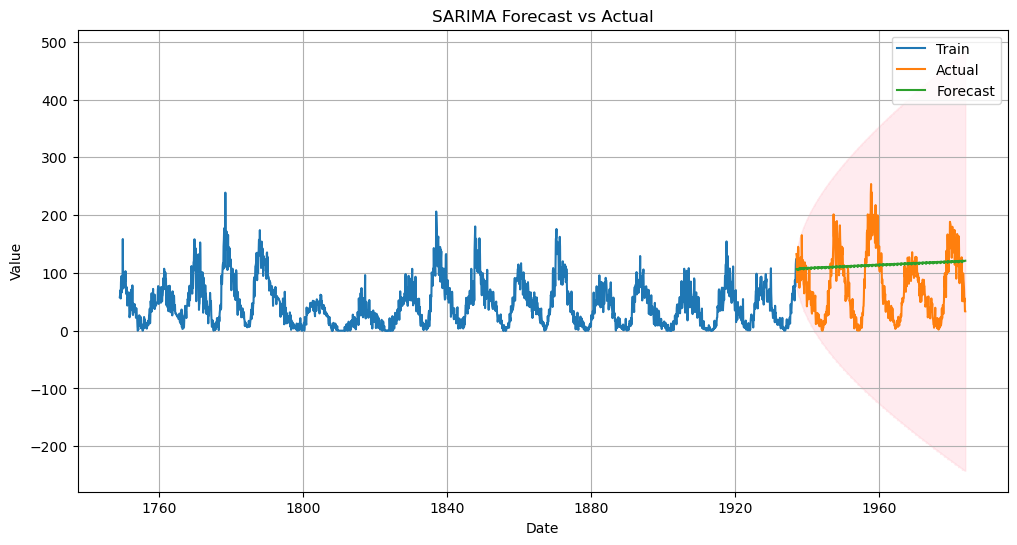

In [23]:
#forecast vs actual visualization
forecast = best_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

Testing parameters: (0, 0, 0, 0) - AIC: 20447.88
Testing parameters: (0, 0, 0, 1) - AIC: 18977.70
Testing parameters: (0, 0, 1, 0) - AIC: 19905.88
Testing parameters: (0, 0, 1, 1) - AIC: 18979.68
Testing parameters: (0, 1, 0, 0) - AIC: 19996.97
Testing parameters: (0, 1, 0, 1) - AIC: 18606.58
Testing parameters: (0, 1, 1, 0) - AIC: 19441.96
Testing parameters: (0, 1, 1, 1) - AIC: 18607.13
Testing parameters: (0, 2, 0, 0) - AIC: 19926.95
Testing parameters: (0, 2, 0, 1) - AIC: 18573.68
Testing parameters: (0, 2, 1, 0) - AIC: 19410.50
Testing parameters: (0, 2, 1, 1) - AIC: 18572.36
Testing parameters: (1, 0, 0, 0) - AIC: 20210.86
Testing parameters: (1, 0, 0, 1) - AIC: 18744.58
Testing parameters: (1, 0, 1, 0) - AIC: 19630.96
Testing parameters: (1, 0, 1, 1) - AIC: 18746.95
Testing parameters: (1, 1, 0, 0) - AIC: 19923.49
Testing parameters: (1, 1, 0, 1) - AIC: 18574.19
Testing parameters: (1, 1, 1, 0) - AIC: 19411.38
Testing parameters: (1, 1, 1, 1) - AIC: 18572.78
Testing parameters: 

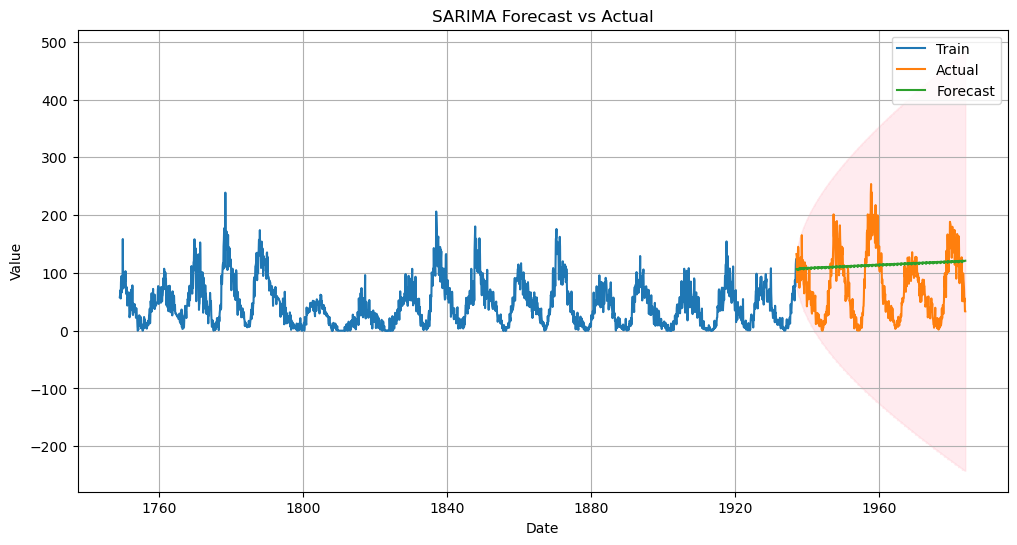

In [27]:
#same but alternative method without 'product' and 'tqdm_notebook' imports
ps = [0, 1, 2]  # AR order
qs = [0, 1, 2]  # MA order
Ps = [0, 1]     # Seasonal AR order
Qs = [0, 1]     # Seasonal MA order
d = 1           # Differencing order
D = 1           # Seasonal differencing order
m = 12          # Seasonal period

# Create all possible combinations of parameters without itertools.product
parameters_list = []
for p in ps:
    for q in qs:
        for P in Ps:
            for Q in Qs:
                parameters_list.append((p, q, P, Q))

# Function to evaluate SARIMA models without tqdm
def optimize_SARIMA(parameters_list, d, D, m):
    """
    Return dataframe with parameters and corresponding AIC
    
    parameters_list - list with (p, q, P, Q) tuples
    d - integration order
    D - seasonal integration order
    m - length of season
    """
    results = []
    best_aic = float('inf')
    
    for param in parameters_list:
        try:
            model = SARIMAX(train, order=(param[0], d, param[1]),
                          seasonal_order=(param[2], D, param[3], m)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        
        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    
        # Print progress (simple alternative to tqdm)
        print(f"Testing parameters: {param} - AIC: {aic:.2f}")
    
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table, best_model, best_param

# Run optimization
result_table, best_model, best_param = optimize_SARIMA(parameters_list, d, D, m)

# Show top 5 parameter combinations
print(result_table.head())

# Best parameters
p, q, P, Q = best_param
print(f'\nBest SARIMA parameters: SARIMA({p},{d},{q})({P},{D},{Q})_{m}')

# %% [markdown]
# ## 7. Forecasting with the Best Model

# %%
# Forecast on test data
forecast = best_model.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_mean, label='Forecast')
plt.fill_between(test.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
#calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test, forecast_mean)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 670.18%


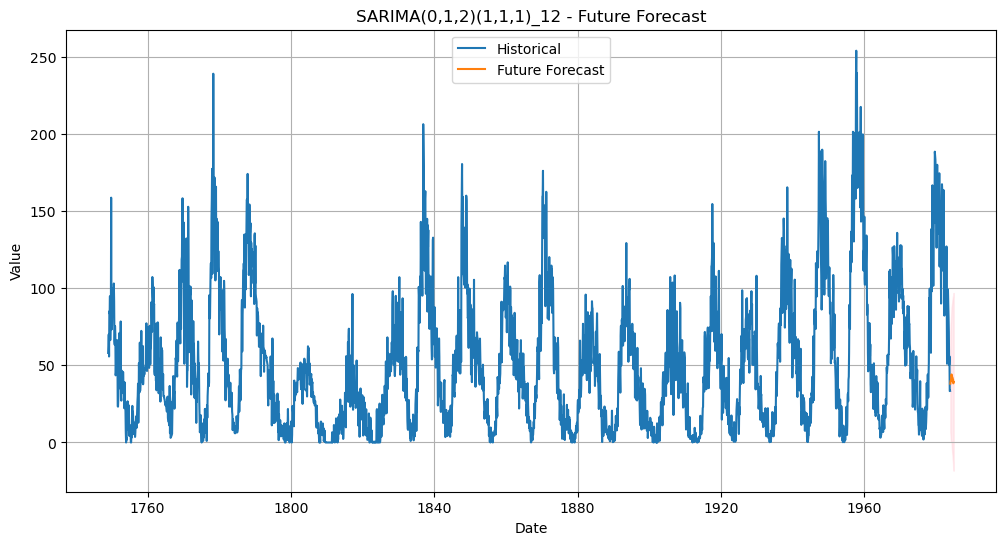

In [26]:
#plot of final forecasting by optimising
final_model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
final_model_fit = final_model.fit(disp=False)

# Forecast next 12 periods
future_steps = 12
future_forecast = final_model_fit.get_forecast(steps=future_steps)
future_mean = future_forecast.predicted_mean
future_ci = future_forecast.conf_int()

# Plot final forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Historical')
plt.plot(future_mean.index, future_mean, label='Future Forecast')
plt.fill_between(future_mean.index,
                future_ci.iloc[:, 0],
                future_ci.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title(f'SARIMA({p},{d},{q})({P},{D},{Q})_{m} - Future Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

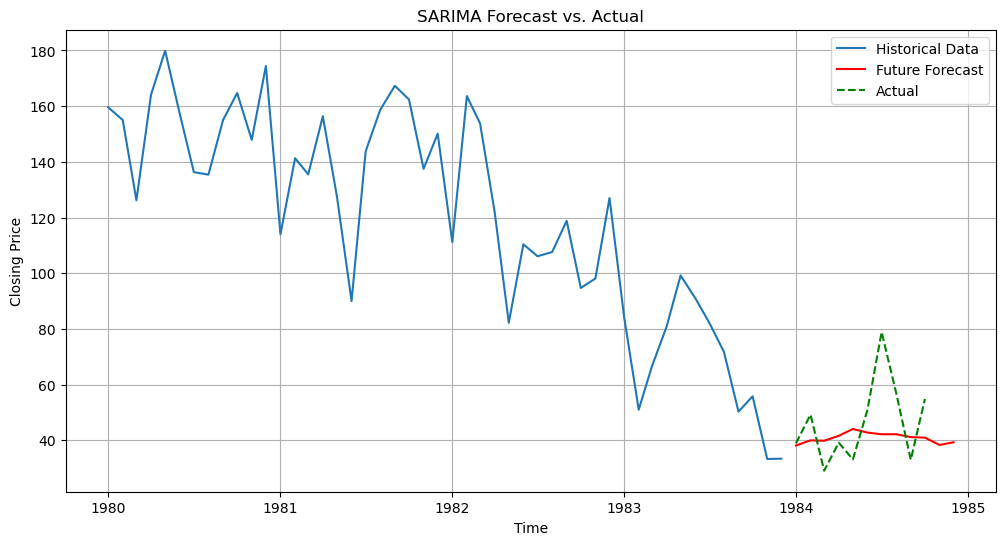

In [34]:
# Plotting Data
actual_data = [38.93, 49.23, 29.08, 39.17, 33.11, 50.99, 78.90, 56.98, 32.99, 54.87]  # Example actual data; Replace
auctualdata=pd.DataFrame({'actual' : actual_data},
                           index=pd.date_range(start='1984-01-01', periods=10, freq='MS'))
plt.figure(figsize=(12, 6))
plt.plot(data.loc['1980-01-01':'1983-12-01'], label='Historical Data') # Historical Data
plt.plot(future_mean.index, future_mean, label='Future Forecast', color = 'red')  # Forecast
plt.plot(auctualdata, color='green', label='Actual', linestyle='--') # Actual values
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.title('SARIMA Forecast vs. Actual')
plt.legend()
plt.grid(True)
plt.show()